In [2]:
### Lets build the model
## Load the data
import pandas as pd
import numpy as np
import datetime
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

tss = pd.read_csv("AusAntidiabeticDrug.csv")
tss["ds"] = pd.to_datetime(tss["ds"])
tss.index = tss["ds"]
tss = tss[["y"]]
print(tss.shape)
tss.head()

(204, 1)


,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [3]:
## Using month as a feature
tss['month'] = [tss.index[i].month for i in range(len(tss))]
## From the insights in session-1 
#There is a large jump in sales in January each year.
tss["Jan"] = tss["month"].apply(lambda x: 1 if x == 1 else 0)

# From box-plot shown session-1
tss["Dec"] = tss["month"].apply(lambda x: 1 if x == 12 else 0)
tss["Feb"] = tss["month"].apply(lambda x: 1 if x == 2 else 0)
tss["June"] = tss["month"].apply(lambda x: 1 if x == 6 else 0)

## Using lag-1 variable - From Auto-Correlation Plot.
tss["lag1"] = tss.y.shift(1) 

## Using the trend
tss["Trend"] = [i for i in range(len(tss))]
tss = tss.fillna(0)
tss.head()

,y,month,Jan,Dec,Feb,June,lag1,Trend
ds,,,,,,,,
1991-07-01,3.526591,7,0,0,0,0,0.000000,0
1991-08-01,3.180891,8,0,0,0,0,3.526591,1
1991-09-01,3.252221,9,0,0,0,0,3.180891,2
1991-10-01,3.611003,10,0,0,0,0,3.252221,3
1991-11-01,3.565869,11,0,0,0,0,3.611003,4


In [4]:
## Split the data into train and test
x_train = tss[tss.index <datetime.datetime(2005, 1, 1, 0, 0, 0)]
x_test = tss[tss.index >=datetime.datetime(2005, 1, 1, 0, 0, 0)]
print(x_train.shape, x_test.shape)

(162, 8) (42, 8)


In [5]:
### Since there is a mulitiplicative effect. Use log of y instead of direct y
x_train["y"] = x_train["y"].apply(lambda x: math.log(x+1))
x_train["lag1"] = x_train["lag1"].apply(lambda x: math.log(x+1))

x_test["lag1"] = x_test["lag1"].apply(lambda x: math.log(x+1))
x_train.head()

,y,month,Jan,Dec,Feb,June,lag1,Trend
ds,,,,,,,,
1991-07-01,1.509969,7,0,0,0,0,0.000000,0
1991-08-01,1.430524,8,0,0,0,0,1.509969,1
1991-09-01,1.447441,9,0,0,0,0,1.430524,2
1991-10-01,1.528445,10,0,0,0,0,1.447441,3
1991-11-01,1.518609,11,0,0,0,0,1.528445,4


In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train[["Jan", "Feb", "June", "Dec", "lag1", "Trend"]], x_train.y)
pred = model.predict(x_test[["Jan", "Feb", "June", "Dec", "lag1",  "Trend"]])
measure = math.pow(mean_squared_error(x_test.y, [math.exp(i)-1 for i in pred]), 0.5)
print("RMSE:", measure)

RMSE: 1.9662146435161436


In [7]:
print("model.coef_: {}".format(model.coef_)) 
print("model.intercept_: {}".format(model.intercept_))

model.coef_: [ 0.238246   -0.22933591 -0.04837378  0.20326329  0.14559292  0.00705468]
model.intercept_: 1.264164500708076


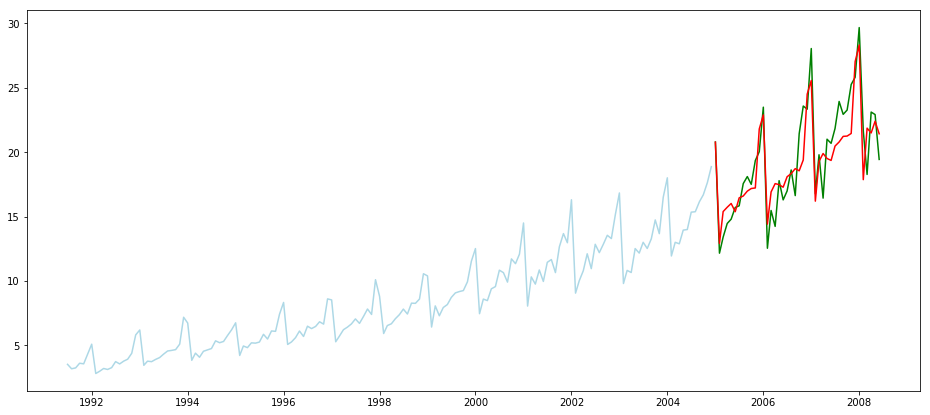

In [8]:
pred = pd.DataFrame(pred)
pred.columns = ["yhat"]
pred.index = x_test.index
pred.head()

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, [math.exp(i)-1 for i in x_train.y], color="lightblue")
plt.plot(x_test.index, x_test.y, color="green")
plt.plot(pred.index, [math.exp(i)-1 for i in pred.values], color="red")
plt.show()

## Residual Plots
- Allows us to see if there is any variation left in the data which is not captured by our model.

Text(0.5, 1.0, 'Actual vs Predicted')

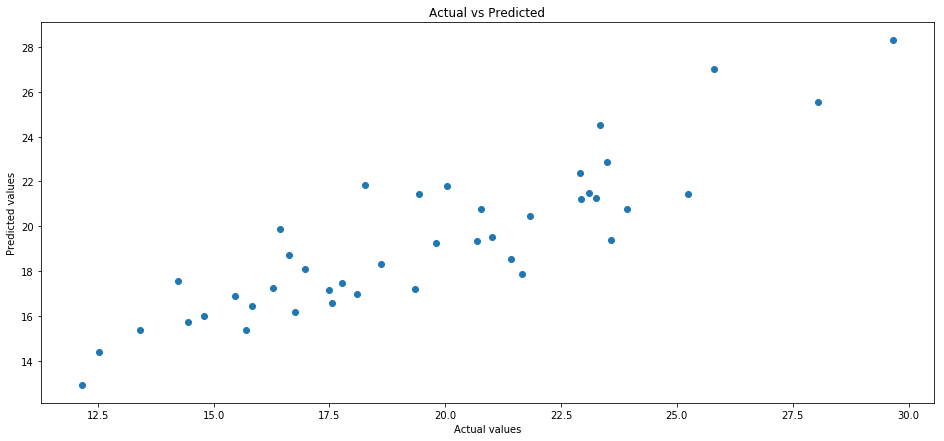

In [9]:
plt.figure(figsize=(16, 7))
plt.scatter(x_test["y"].values, [math.exp(i)-1 for i in pred["yhat"].values])
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")

Text(0.5, 1.0, 'Residual plots')

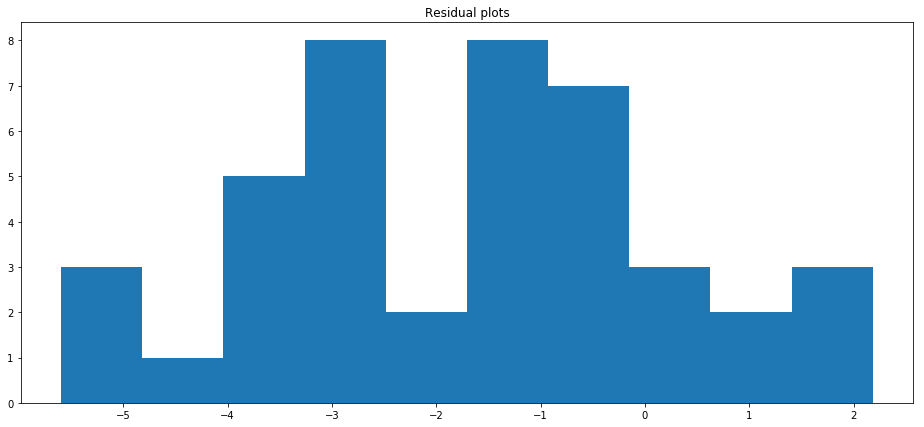

In [10]:
plt.figure(figsize=(16, 7))
plt.hist([j -  math.exp(i)-1 for i, j in zip(pred["yhat"].values, x_test.y)])
plt.title("Residual plots")

Text(0.5, 1.0, 'Residual Plots')

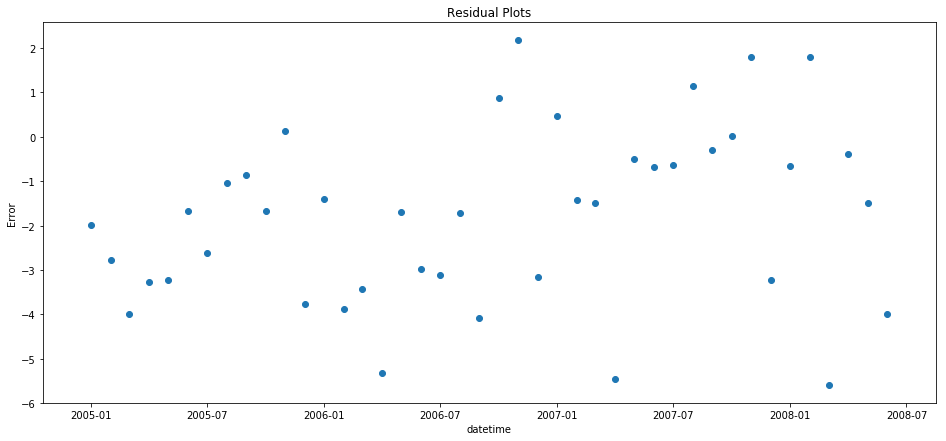

In [11]:
error = [j -  math.exp(i)-1 for i, j in zip(pred["yhat"].values, x_test.y)]
datetime = x_test.index

plt.figure(figsize=(16, 7))
plt.scatter(datetime, error)
plt.xlabel("datetime")
plt.ylabel("Error")
plt.title("Residual Plots")

## Insights:
- The errors are random, have a constant mean and normally distributed.
- Using Simple Linear regression and basic feature engineering we reached an RMSE value of 1.96, which is still high compared to ARIMA models, but unlike arima models, u can easily interpret your results here.
- Careful Feature Engineering and use of complex models will reduce your RMSE value further, but there is a cost and you should choose between complexity vs interpretibility. 